In [1]:
import os
from PIL import Image
import math
import time
from dataclasses import dataclass
from pathlib import Path
from typing import Sequence, Tuple, Union, Optional, Any, Dict, List, Iterator
import unittest
from abc import ABC, abstractmethod
from matplotlib import pyplot as plt

import numpy as np
import torch

from torch import sigmoid
from torch import nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import argparse
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset, random_split
from torch.utils.data import Subset, DataLoader
import random


device: torch.device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device=torch.device("mps")

print(f"using device: {device}")

rnd_seed = 412
random.seed(rnd_seed)
seed = random.randint(0, 101)
torch.manual_seed(seed)
np.random.seed(seed)

using device: mps


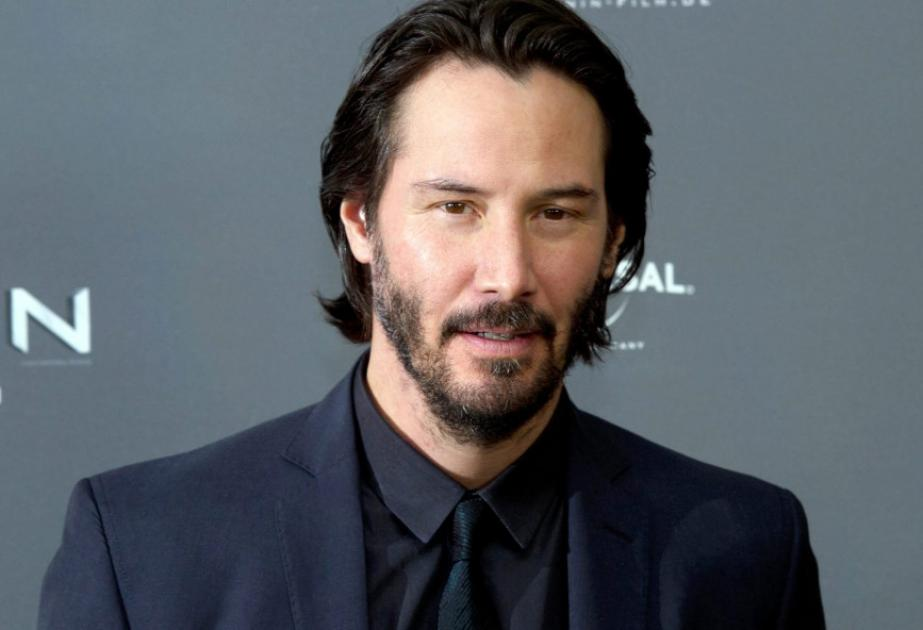

In [2]:
IMAGE_PATH = Path("keanu_0.jpg")
image = Image.open(IMAGE_PATH)
image = image.convert("RGB")
image

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
image_transformed = transform(image)

In [4]:
class MyMedianFilter:
    '''Median Filter with reflection padding'''
    
    def __init__(self, kernel_size: int = 3):
        self.size = kernel_size
    
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if self.size < 1 or self.size % 2 == 0:
            raise ValueError("kernel size must be odd and >= 1")
        k = self.size
        p = k // 2
        
        C, H, W = x.shape
        if H < 2 or W < 2:
            raise ValueError("h, w must be >= 2 for reflection")
        if p > H - 1 or p > W - 1:
            raise ValueError("kernel size too large, man")
        
        # reflect pad width
        if p <= 0:
            xw = x
        else:
            left_w = x[:, :, 1:p+1].flip(-1)
            right_w = x[:, :, W-p-1:W-1].flip(-1)
            xw = torch.cat([left_w, x, right_w], dim=2)
        
        # reflect pad height
        if p <= 0:
            xp = xw
        else:
            top_h = xw[:, 1:p+1, :].flip(-2)
            bottom_h = xw[:, H-p-1:H-1, :].flip(-2)
            xp = torch.cat([top_h, xw, bottom_h], dim=-2)
            
        patches = xp.unfold(1, k, 1).unfold(2, k, 1)
        K = k * k
        patches = patches.contiguous().view(C, H, W, K)
        sorted_vals, _ = torch.sort(patches, dim=-1
                                    )
        
        if K % 2 == 1:
            med = sorted_vals[..., K // 2]
        else:
            med = .5 * (sorted_vals[..., K // 2 - 1] + sorted_vals[..., K // 2])
            
        return med
    

In [5]:
def imshow(x: torch.Tensor, title: str = ""):
    xnp = x.permute(1, 2, 0).numpy()
    plt.imshow(xnp)
    plt.title(title)
    plt.axis('off')
    plt.show()

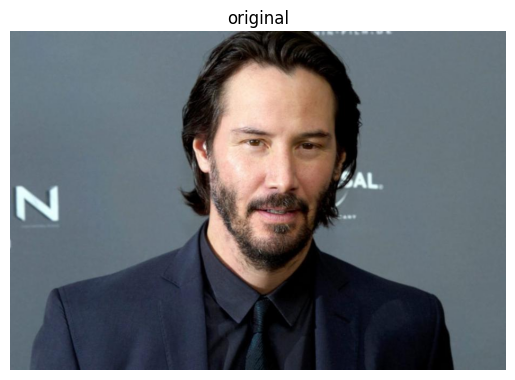

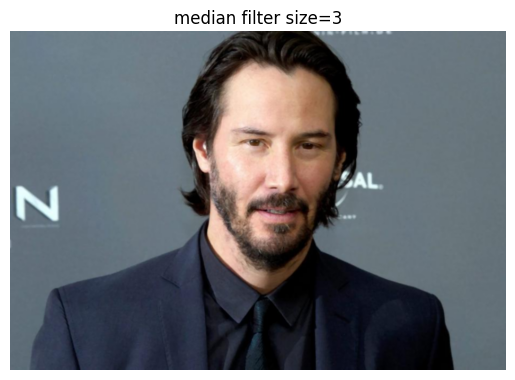

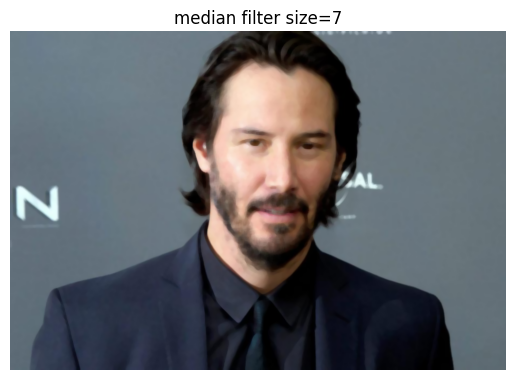

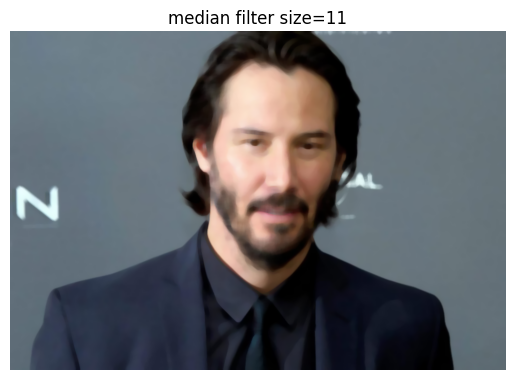

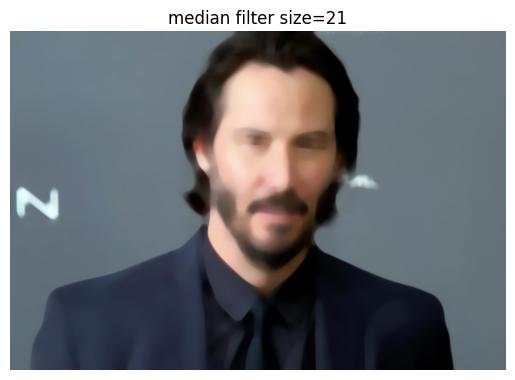

In [6]:
imshow(image_transformed, title='original') # type: ignore

size = [3, 7, 11, 21]

for s in size:
    filter = MyMedianFilter(kernel_size=s)
    filtered_image = filter(image_transformed) # type: ignore
    imshow(filtered_image, title=f'median filter size={s}')
